In [1]:
import pandas as pd
df = pd.read_csv('Train.csv')
del df['id']
df.head()

,content,category
0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa
1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara
2,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa
3,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo
4,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa


In [2]:
from io import StringIO
col = ['category', 'content']
df = df[col]
df = df[pd.notnull(df['content'])]
df.columns = ['category', 'content']
df['category_id'] = df['category'].factorize()[0]
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
df.head()

,category,content,category_id
0,Kitaifa,SERIKALI imesema haitakuwa tayari kuona amani...,0
1,Biashara,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",1
2,Kitaifa,SERIKALI imetoa miezi sita kwa taasisi zote z...,0
3,michezo,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,2
4,Kitaifa,WATANZANIA wamekumbushwa kusherehekea sikukuu...,0


<Figure size 576x432 with 0 Axes>

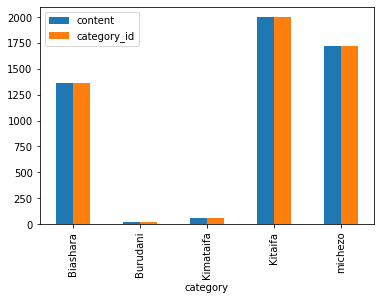

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category').count().plot.bar(ylim=0)
plt.show()

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))

features = tfidf.fit_transform(df.content).toarray()
labels = df.category_id
features.shape

(5151, 52264)

In [5]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Biashara':
  . Most correlated unigrams:
. bidhaa
. wateja
  . Most correlated bigrams:
. soko la
. benki hiyo
# 'Burudani':
  . Most correlated unigrams:
. up
. brown
  . Most correlated bigrams:
. kumi bora
. ya urembo
# 'Kimataifa':
  . Most correlated unigrams:
. trump
. corona
  . Most correlated bigrams:
. wanandoa hao
. virusi hivyo
# 'Kitaifa':
  . Most correlated unigrams:
. timu
. mchezo
  . Most correlated bigrams:
. mchezo wa
. mchezo huo
# 'michezo':
  . Most correlated unigrams:
. timu
. mchezo
  . Most correlated bigrams:
. mchezo wa
. mchezo huo


----

Naive Bayes Classifier

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['content'], df['category'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [24]:
print(clf.predict(count_vect.transform(["Mwenyekiti wa Chama Cha Mapinduzi (CCM) Taifa Rais John Magufuli,  amekipongeza chama hicho kwa kutimiza miaka 43 tangu kuzaliwa kwake.Katika salamu zake kupitia mtandao wa kijamii wa Twitter, Rais Magufuli ametaka wakati wa kusherehekea siku hiyo muhimu  kuendelezwa  kwa  misingi ya chama hicho na kusimamiwa kwa utekelezaji wa ilani ya CCM.Pia ametaka Wananchama wote wa CCM kudumisha amani, upendo na mshikamano.CCM ilizaliwa Februari Tano mwaka 1977 kutokana na kuungana kwa Chama cha  TANU kilichokua kikitawala Tanzania Bara na ASP kilichokua kikitawala Zanziba kwa wakati huo."])))

['Kitaifa']


----

Experiments

Logistic Regression
(Multinomial) Naive Bayes
Linear Support Vector Machine
Random Forest

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

NameError: name 'MultinomialNB' is not defined

In [26]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.874393
LogisticRegression        0.862550
MultinomialNB             0.797325
RandomForestClassifier    0.652111
Name: accuracy, dtype: float64

LinearSVC and Logistic Regression perform better than the other two classifiers, with LinearSVC having a slight advantage with a median accuracy of around 87%

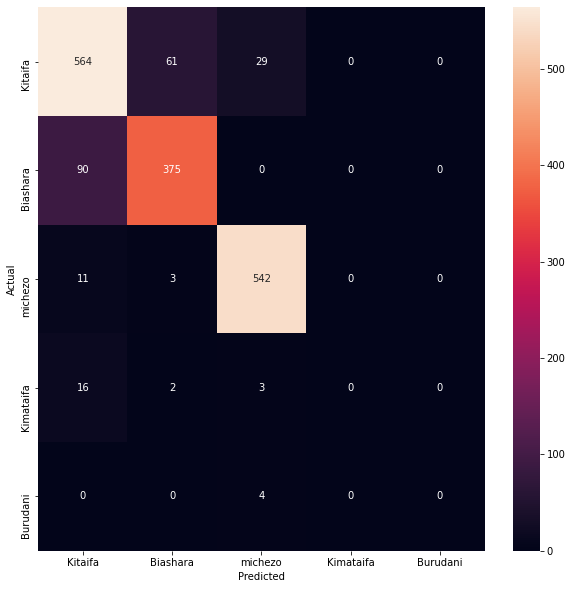

In [28]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [29]:
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 'content']])
            print('')

'Biashara' predicted as 'Kitaifa' : 90 examples.


,category,content
862,Biashara,"WAZIRI wa Ujenzi, Uchukuzi na Mawasiliano, Is..."
866,Biashara,MAUZO ya bima ya uingizaji mizigo nchini yame...
1793,Biashara,SERIKALI imefanya uwekezaji wa Sh trilioni 54...
1419,Biashara,"Naibu Waziri wa Kilimo, Mifugo na Uvuvi, Will..."
1696,Biashara,Agizo hilo lilitolewa juzi na Mkuu wa Wilaya ...
...,...,...
768,Biashara,"Akisoma hotuba kwa niaba ya mama Pinda, Naibu..."
4557,Biashara,"Mpango huo uliopewa jina la Kili Challenge, u..."
4368,Biashara,"Waziri wa Nchi, Ofisi ya Rais (Uhusiano na Ur..."
3502,Biashara,MKOA wa Morogoro unaandaa mkakati wa kilimo w...



'michezo' predicted as 'Kitaifa' : 11 examples.


,category,content
3567,michezo,Ameyasema hayo baada ya Baraza la Sanaa la Ta...
1771,michezo,"Kauli ya Diamond, imekuja juzi baada ya kumal..."
2509,michezo,"KATIBU Mkuu Kiongozi, ambaye pia ni Mkuu wa U..."
4299,michezo,Hatua hiyo imekuja baada ya mshitakiwa Masoga...
464,michezo,"MKUU wa Mkoa wa Morogoro, Loata ole Sanare, a..."
3234,michezo,"Mbunge wa Chalinze, Ridhiwani Kikwete leo ame..."
565,michezo,Lulu aliye nje kwa dhamana atapanda kizimbani...
3362,michezo,Alisema uchunguzi wa sampuli ya mkojo wa Wema...
3633,michezo,AGIZO lilitolewa na Rais John Magufuli akiwa ...
3332,michezo,"WAZIRI Mkuu, Kassim Majaliwa ameiagiza Wizara..."



'Kimataifa' predicted as 'Kitaifa' : 16 examples.


,category,content
39,Kimataifa,Serikali ya Kenya imetangaza kuongeza mishaha...
3528,Kimataifa,"KIONGOZI wa Kanisa Katoliki duniani, Papa Fra..."
1593,Kimataifa,.Mahakama nchini Afrika Kusini imetoa hati ya ...
3917,Kimataifa,"Wanafunzi katika Chuo Kikuu cha Cape Town, Af..."
575,Kimataifa,SERIKALI imetoa tahadhari kwa shule 108 za ms...
2033,Kimataifa,.Salamu za pole zimeendelea kutolewa kwa Rais ...
2510,Kimataifa,RAIS Salva Kiir amesema yuko tayari kukutana ...
649,Kimataifa,".Rais wa Pili wa Kenya, Daniel Toroitich arap ..."
3194,Kimataifa,Serikali ya Gabon imefanikiwa kuzima jaribio ...
872,Kimataifa,"SAKATA la binti wa Uingereza, Shamima Begum a..."



'Kitaifa' predicted as 'Biashara' : 61 examples.


,category,content
4345,Kitaifa,BENKI ya Maendeleo ya Afrika (AfDB) inataraji...
4309,Kitaifa,SERIKALI ya Mapinduzi ya Zanzibar imesema uvu...
2651,Kitaifa,KAMPUNI ya LafargeHolcim Tanzania inayotengen...
4834,Kitaifa,TANZANIA na Uganda zimeeleza kuwa mipango ya ...
4545,Kitaifa,SERIKALI ya Mapinduzi ya Zanzibar imesema had...
...,...,...
2553,Kitaifa,"NMB ni moja ya benki zilizopo nchini, lakini ..."
4479,Kitaifa,KATIKA msimu wa kuelekea Krismasi na Mwaka Mp...
1273,Kitaifa,WAKALA wa Mabasi Yaendayo Haraka (DART) ambao...
3119,Kitaifa,MATUNDA ya uwekezaji mkubwa katika kiwanda ch...



'Kitaifa' predicted as 'michezo' : 29 examples.


,category,content
1960,Kitaifa,KLABU ya Azam FC imewatema nyota wanane kweny...
1299,Kitaifa,MSANII wa muziki nchini Richard Mavoko amekan...
1687,Kitaifa,"KOCHA Mkuu wa Simba, Patrick Aussems amesema ..."
1115,Kitaifa,SIMBA jana ilifungwa mabao 5-4 na Sevilla ya ...
4079,Kitaifa,WAWAKILISHI wa Tanzania katika michuano ya Kl...
2036,Kitaifa,"MWEZI uliopita Mbunge wa Geita Vijijini, Jose..."
2102,Kitaifa,MAHAKAMA ya Hakimu Mkazi Kisutu imeshindwa ku...
2620,Kitaifa,"SIMBA, jana iliendelea vema na kampeni za kut..."
728,Kitaifa,MWANARIADHA Joshua Cheptegei amekuwa Mganda w...
1852,Kitaifa,ZAIDI ya Shilingi milioni 300 zinatarajiwa ku...


In [30]:
model.fit(features, labels)

N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Biashara':
  . Top unigrams:
       . amesema
       . biashara
  . Top bigrams:
       . benki hiyo
       . bei ya
# 'Burudani':
  . Top unigrams:
       . brown
       . up
  . Top bigrams:
       . ya urembo
       . ameipongeza kampuni
# 'Kimataifa':
  . Top unigrams:
       . uingereza
       . virusi
  . Top bigrams:
       . nchi hiyo
       . taifa hilo
# 'Kitaifa':
  . Top unigrams:
       . magufuli
       . wananchi
  . Top bigrams:
       . john magufuli
       . rais john
# 'michezo':
  . Top unigrams:
       . timu
       . michezo
  . Top bigrams:
       . msanii huyo
       . klabu hiyo


In [32]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['category'].unique()))

              precision    recall  f1-score   support

     Kitaifa       0.83      0.86      0.84       654
    Biashara       0.85      0.81      0.83       465
     michezo       0.94      0.97      0.96       556
   Kimataifa       0.00      0.00      0.00        21
    Burudani       0.00      0.00      0.00         4

    accuracy                           0.87      1700
   macro avg       0.52      0.53      0.53      1700
weighted avg       0.86      0.87      0.86      1700



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


----

Creating Submit File(s)

In [33]:
test_df = pd.read_csv('Test.csv')

In [35]:
#del df['id']
test_df.head()

,swahili_id,content
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,"MKUU wa Wilaya ya Bahi, Mkoani Dodoma, Mwanah..."
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,"MWISHONI mwa wiki hii, Timu ya Soka ya Taifa,..."
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,THAMANI ya mauzo ya bidhaa za Afrika Masharik...
3,00868eeee349e286303706ef0ffd851f39708d37,MENEJA Mawasiliano na Utetezi wa asasi ya AGP...
4,00a5cb12d3058dcf2e42f277eee599992db32412,"WAZIRI wa Kilimo, Japhet Hasunga amesema seri..."


In [42]:
test_features = tfidf.fit_transform(test_df.content).toarray()
test_features.shape

(1288, 15417)

In [ ]:
test_pred = model.predict(test_features)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])